In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from bluepy.circuit import Circuit
from bluepy.enums import Cell, Synapse
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [2]:
def build_dist_mat(c, gids):
    """Builds PC-PC distance matrix"""

    pos = c.cells.get(gids)[["x", "y", "z"]].values
    dists = squareform(pdist(pos))

    return dists


def build_conn_mat(c, pre_gids, post_gids):
    """Builds pre-post binary connectivity matrix"""

    syns = c.connectome.pathway_synapses(pre_gids, post_gids, properties=[Synapse.PRE_GID, Synapse.POST_GID])
    conns = syns.drop_duplicates()
    # this assumes that gids are sorted (and that's how bluepy returns them...)
    pre_idx = np.searchsorted(pre_gids, conns[Synapse.PRE_GID])
    post_idx = np.searchsorted(post_gids, conns[Synapse.POST_GID])

    conns = np.zeros((len(pre_gids), len(post_gids)))
    conns[pre_idx, post_idx] = 1

    return conns


def calc_conn_prob(conns, dists, max_dist, bin_size, within_bin=True):
    """Bins distance and calculates connection probability across the bins
    If within_bin is True, the connection probability is calculated within each bin
    If False, it means that the connection probability is between 0 and x (max distance)
    """

    bins = np.arange(0, max_dist+1, bin_size)[1:]
    bin_dists = np.digitize(dists, bins)
        
    conn_probs = []
    for i, ub in enumerate(bins):
        if within_bin:
            dist_idx = np.where(bin_dists == i)
        else:
            dist_idx = np.where(bin_dists <= i)
        total = len(dist_idx[0])
        conn = np.sum(conns[dist_idx])
        conn_probs.append(conn / total)

    return bins, conn_probs

In [3]:
MICROCIRCUIT = False
within_bin = True

if MICROCIRCUIT:
    root = "/gpfs/bbp.cscs.ch/project/proj42/circuits/CA1.O1/20190306/"
else:
    root = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/'
    output_path = root + '/validation/'

    
circuit_path = root + 'CircuitConfig'
c = Circuit(circuit_path)

In [4]:
output_path = root + 'validation/'
if not os.path.exists(output_path):
    os.makedirs(output_path,exist_ok=True)

In [5]:
if MICROCIRCUIT:
    gids = c.cells.ids({Cell.REGION:"@mc2.*", Cell.MTYPE:"SP_PC"}) # central column
else:
    
    c_targets = list(c.cells.targets)
    for i in c_targets:
        if not i.startswith('cylinders'):
            if i.startswith('cylinder300'):
                print(i)
                selected_cylinder = i
                break
    gids = c.cells.ids({'$target':selected_cylinder, Cell.MTYPE:"SP_PC"}) # central column
    

cylinder300_inh


In [7]:
bin_size = 5
conns = build_conn_mat(c, gids, gids)
dists = build_dist_mat(c, gids)
bins, conn_probs = calc_conn_prob(conns, dists, 500, bin_size, within_bin=True)

In [8]:
len(gids) #only exc

5536

In [9]:
len(np.where(conns==1)[0]) / (len(gids)*len(gids))

0.018111124713906246

In [13]:
np.save(output_path+'bins_conn_probs_pcpc',[bins, conn_probs])

### Plotting

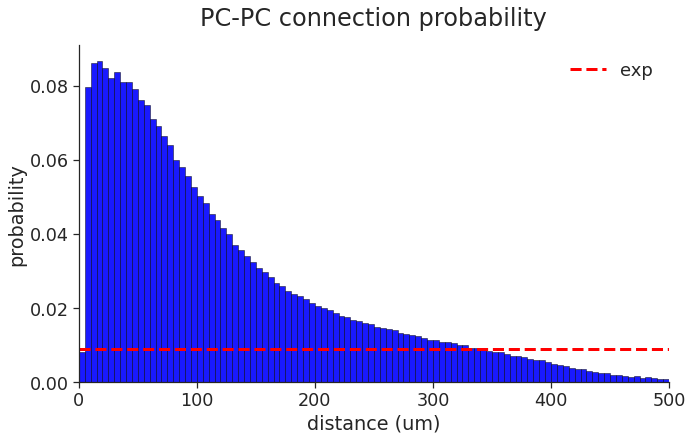

In [11]:
if within_bin:

    sns.set(style="ticks", font_scale=1.6)

    fig = plt.figure(figsize=(10, 6.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(bins-bin_size/2, conn_probs, width=bin_size, align="center", color="blue", edgecolor="black", linewidth=0.5, alpha=0.9)
    ax.axhline(9.0/989, color="red", ls="--", label="exp", linewidth=3)
    ax.set_title("PC-PC connection probability", fontsize=24, y=1.04)
    ax.set_xlabel("distance (um)")
    ax.set_ylabel("probability")
    ax.set_xlim(bins[0]-bin_size, bins[-1])
    ax.legend(frameon=False, fontsize=18)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.tight_layout()

    fig_name = root + "validation/PC_connection_prob_within_bin.png"
    #fig.savefig(fig_name)
    fig.show()

In [7]:
if not within_bin:

    sns.set(style="ticks", font_scale=1.6)

    fig = plt.figure(figsize=(10, 6.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(bins, conn_probs, label='model')
    ax.scatter(200, 9.0/989, color="red", label='exp')
    ax.set_title("PC-PC connection probability", fontsize=24, y=1.04)
    ax.set_xlabel("max distance (um)")
    ax.set_ylabel("probability")
    ax.set_xlim(bins[0]-bin_size, bins[-1])
    ax.legend(frameon=False, fontsize=18)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.tight_layout()

    fig_name = root + "validation/new_PC_connection_prob.png"
    fig.savefig(fig_name)
    fig.show()

### Analysis

In [10]:
if MICROCIRCUIT:
    gids = c.cells.ids({Cell.REGION:"@mc2.*"}) # central column
else:
    gids = c.cells.ids({'$target':selected_cylinder}) # central column
conns = build_conn_mat(c, gids, gids)

In [6]:
def conn_prob_from_matrix(matrix):
    '''Calculate connection probability from a connectivity matrix'''
    h,w = matrix.shape
    return sum(sum(matrix)) / (h*w)

def conn_prob_from_full_matrix(circ, full_matrix, all_gids, pre_gids, post_gids):
    pre_idx = [int(np.where(all_gids==idx)[0]) for idx in pre_gids]
    post_idx = [int(np.where(all_gids==idx)[0]) for idx in post_gids]
    temp = full_matrix[pre_idx, :]
    selected = temp[:, post_idx]
    return conn_prob_from_matrix(selected)

### Validation

In [7]:
bio_path = root + 'bioname/connection_probability.txt'

In [8]:
df = pd.read_csv(bio_path, sep='\t', index_col = False)

In [9]:
df.head()

,Pre,Post,slice,xmin,xmax,n,N,p
0,SP_PC,SP_PC,450,0,500,11,989,0.011122
1,SP_PC,SO_OLM,475,0,500,12,36,0.333333
2,SP_PC,SP_PVBC,450,0,500,16,124,0.129032
3,SP_PC,BS,450,0,500,2,4,0.500000
4,SP_PC,BS,475,0,500,8,53,0.150943


In [10]:
df

,Pre,Post,slice,xmin,xmax,n,N,p
0,SP_PC,SP_PC,450,0,500,11,989,0.011122
1,SP_PC,SO_OLM,475,0,500,12,36,0.333333
2,SP_PC,SP_PVBC,450,0,500,16,124,0.129032
3,SP_PC,BS,450,0,500,2,4,0.500000
4,SP_PC,BS,475,0,500,8,53,0.150943
5,SP_PC,SP_CCKBC,450,0,500,8,81,0.098765
6,SP_PC,SR_SCA,450,0,500,0,32,0.000000
7,SP_PC,BC,475,0,500,9,195,0.046154
8,SP_PC,SP_INT,475,0,500,23,371,0.061995
9,INT,SP_PC,450,0,500,6,21,0.285714


In [11]:
# remove datapoint with n<10
df.drop([3, 11, 13, 17], inplace=True)

In [12]:
df['mod_mean'] = 0.0
df['mod_std'] = 0.0

In [17]:
for index, row in df.iterrows():
    
    pre_mtype = row['Pre']
    post_mtype = row['Post']

    if MICROCIRCUIT:
        pre_gids = c.cells.ids({Cell.REGION:"@mc2.*", '$target':pre_mtype})
        post_gids = c.cells.ids({Cell.REGION:"@mc2.*", '$target':post_mtype})
    else:      
        pre_gids1 = c.cells.ids({'$target':selected_cylinder})
        pre_gids2 = c.cells.ids({'$target':pre_mtype})
        pre_gids = np.intersect1d(pre_gids1, pre_gids2)
        post_gids1 = c.cells.ids({'$target':selected_cylinder})
        post_gids2 = c.cells.ids({'$target':post_mtype})
        post_gids = np.intersect1d(post_gids1, post_gids2)

    df.loc[index, 'mod_mean'] = conn_prob_from_full_matrix(c, conns, gids, pre_gids, post_gids)
    
    print(row['Pre'], row['Post'], 'done')

SP_PC SP_PC done
SP_PC SO_OLM done
SP_PC SP_PVBC done
SP_PC BS done
SP_PC SP_CCKBC done
SP_PC SR_SCA done
SP_PC BC done
SP_PC SP_INT done
INT SP_PC done
SP_PVBC SP_PC done
SP_CCKBC SP_PC done
BC SP_PC done
BC SP_PC done
BC SP_PC done
SO SLM done
SR_SCA SR_SCA done


In [13]:
def conn_class(pre, post):
    if (pre=='SP_PC')&(post=='SP_PC'):
        return 'ee'
    if (pre=='SP_PC')&(post!='SP_PC'):
        return 'ei'
    if (pre!='SP_PC')&(post=='SP_PC'):
        return 'ie'
    else:
        return 'ii'

In [19]:
df['connection_class'] = [conn_class(pre, post) for pre, post in zip(df['Pre'].values, df['Post'].values)]

In [20]:
df.to_csv(root + 'validation/connection_probability_validation.txt', sep=' ')

In [15]:
df = pd.read_csv(root + 'validation/connection_probability_validation.txt',index_col=0,sep=' ')
df

,Pre,Post,slice,xmin,xmax,n,N,p,mod_mean,mod_std,connection_class
0,SP_PC,SP_PC,450,0,500,11,989,0.011122,0.018111,0.0,ee
1,SP_PC,SO_OLM,475,0,500,12,36,0.333333,0.125439,0.0,ei
2,SP_PC,SP_PVBC,450,0,500,16,124,0.129032,0.034643,0.0,ei
4,SP_PC,BS,475,0,500,8,53,0.150943,0.050640,0.0,ei
5,SP_PC,SP_CCKBC,450,0,500,8,81,0.098765,0.022684,0.0,ei
6,SP_PC,SR_SCA,450,0,500,0,32,0.000000,0.028209,0.0,ei
7,SP_PC,BC,475,0,500,9,195,0.046154,0.030115,0.0,ei
8,SP_PC,SP_INT,475,0,500,23,371,0.061995,0.035893,0.0,ei
9,INT,SP_PC,450,0,500,6,21,0.285714,0.081226,0.0,ie
10,SP_PVBC,SP_PC,450,0,500,49,167,0.293413,0.047480,0.0,ie


In [26]:
df.N.mean()

180.5625

Text(0.5, 1.0, 'Experimental EI connection probabilities')

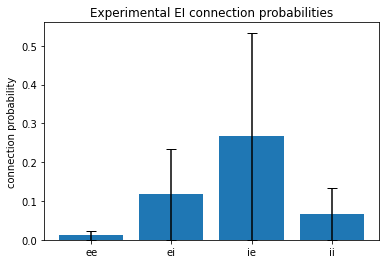

In [27]:
exp_conn_prob_means = []
exp_conn_prob_stds = []
conn_classes =  ['ee','ei','ie','ii']

for i in conn_classes:
    exp_data = df[df.connection_class==i].p.values
    exp_conn_prob_means.append(exp_data.mean())
    exp_conn_prob_stds.append(exp_data.mean())
    

plt.bar(conn_classes, exp_conn_prob_means, yerr=exp_conn_prob_stds, capsize=5)
plt.ylabel('connection probability')
plt.title('Experimental EI connection probabilities')

In [21]:
from datetime import datetime

/gpfs/bbp.cscs.ch/home/kurban/venv3-lab/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


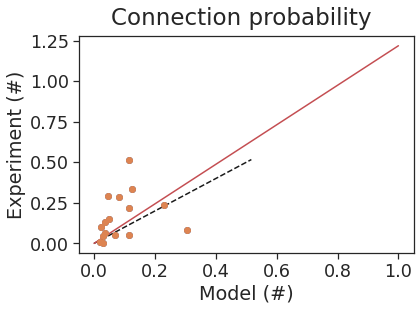

In [22]:
plt.clf
x = df['mod_mean'].values
y = df['p'].values
l = np.linspace(0, max(x.max(), y.max()), 50)
fig, ax = plt.subplots()
fig.suptitle('Connection probability')
ax.plot(x, y, 'o')
ax.errorbar(x, y, xerr=df['mod_std'].values, fmt='o', ecolor='g', capthick=2)
ax.plot(l, l, 'k--')
ax.set_xlabel('Model (#)')
ax.set_ylabel('Experiment (#)')

# fit to assess the deviation from experimental data
if True:
    m = np.linalg.lstsq(x.reshape(-1,1), y)[0][0]
    b = 0
    
    x_fit = np.arange(0, 1.1, 0.1)
    y_fit = m*x_fit + b
    ax.plot(x_fit, y_fit, 'r', label='fit')

timestamp = datetime.now().strftime('%Y%m%dT%H%M%S')

filename = root + 'validation/connection_probability_' + timestamp + '.png'

plt.savefig(filename)
plt.show()

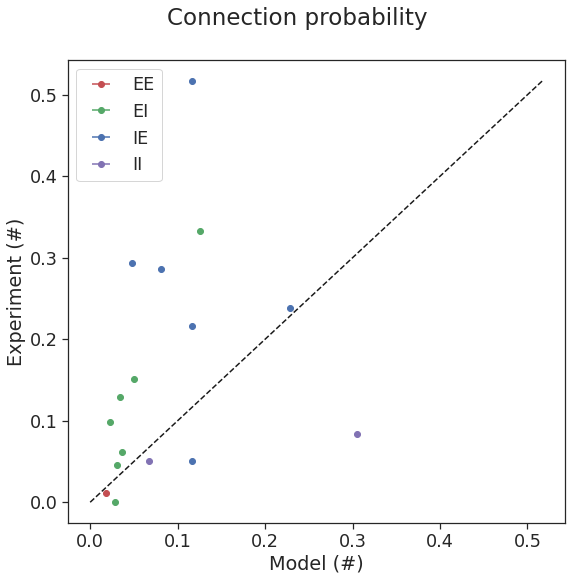

In [23]:
plt.clf
x = df['mod_mean'].values
y = df['p'].values
l = np.linspace(0, max(x.max(), y.max()), 50)
fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Connection probability')

x_ee = df[df['connection_class']=='ee']['mod_mean'].values
x_ee_err = df[df['connection_class']=='ee']['mod_std'].values
y_ee = df[df['connection_class']=='ee']['p'].values
ax.errorbar(x_ee, y_ee, xerr=x_ee_err, fmt='ro', capthick=2, label='EE')

x_ei = df[df['connection_class']=='ei']['mod_mean'].values
x_ei_err = df[df['connection_class']=='ei']['mod_std'].values
y_ei = df[df['connection_class']=='ei']['p'].values
ax.errorbar(x_ei, y_ei, xerr=x_ei_err, fmt='go', capthick=2, label='EI')

x_ie = df[df['connection_class']=='ie']['mod_mean'].values
x_ie_err = df[df['connection_class']=='ie']['mod_std'].values
y_ie = df[df['connection_class']=='ie']['p'].values
ax.errorbar(x_ie, y_ie, xerr=x_ie_err, fmt='bo', capthick=2, label='IE')

x_ii = df[df['connection_class']=='ii']['mod_mean'].values
x_ii_err = df[df['connection_class']=='ii']['mod_std'].values
y_ii = df[df['connection_class']=='ii']['p'].values
ax.errorbar(x_ii, y_ii, xerr=x_ii_err, fmt='mo', capthick=2, label='II')

# fit to assess the deviation from experimental data
if False:
    m = np.linalg.lstsq(x.reshape(-1,1), y)[0][0]
    b = 0
    x_fit = np.arange(0, 1.1, 0.1)
    y_fit = m*x_fit + b
    ax.plot(x_fit, y_fit, 'k', label='fit')

ax.legend(loc=2)

fig.tight_layout()

ax.plot(l, l, 'k--')
ax.set_xlabel('Model (#)')
ax.set_ylabel('Experiment (#)')

timestamp = datetime.now().strftime('%Y%m%dT%H%M%S')

filename = root + 'validation/connection_probability_' + timestamp + '.png'

plt.savefig(filename)
plt.show()

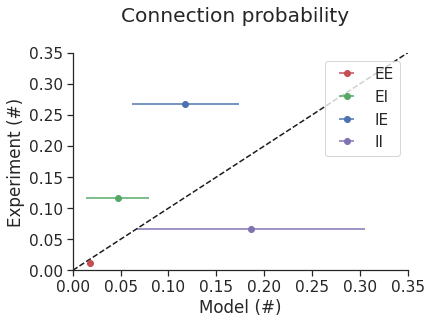

In [24]:
# make a plot to show average per connection class

sns.set(style="ticks", font_scale=1.4)

x = df['mod_mean'].values
y = df['p'].values
l = np.linspace(0, max(x.max(), y.max()), 50)
fig, ax = plt.subplots()
fig.suptitle('Connection probability', y=1.04)

x_ee = df[df['connection_class']=='ee']['mod_mean'].values.mean()
x_ee_err = df[df['connection_class']=='ee']['mod_mean'].values.std()
y_ee = df[df['connection_class']=='ee']['p'].values.mean()
ax.errorbar(x_ee, y_ee, xerr=x_ee_err, fmt='ro', capthick=2, label='EE')

x_ei = df[df['connection_class']=='ei']['mod_mean'].values.mean()
x_ei_err = df[df['connection_class']=='ei']['mod_mean'].values.std()
y_ei = df[df['connection_class']=='ei']['p'].values.mean()
ax.errorbar(x_ei, y_ei, xerr=x_ei_err, fmt='go', capthick=2, label='EI')

x_ie = df[df['connection_class']=='ie']['mod_mean'].values.mean()
x_ie_err = df[df['connection_class']=='ie']['mod_mean'].values.std()
y_ie = df[df['connection_class']=='ie']['p'].values.mean()
ax.errorbar(x_ie, y_ie, xerr=x_ie_err, fmt='bo', capthick=2, label='IE')

x_ii = df[df['connection_class']=='ii']['mod_mean'].values.mean()
x_ii_err = df[df['connection_class']=='ii']['mod_mean'].values.std()
y_ii = df[df['connection_class']=='ii']['p'].values.mean()
ax.errorbar(x_ii, y_ii, xerr=x_ii_err, fmt='mo', capthick=2, label='II')

# fit to assess the deviation from experimental data
if False:
    m = np.linalg.lstsq(x.reshape(-1,1), y)[0][0]
    b = 0
    x_fit = np.arange(0, 1.1, 0.1)
    y_fit = m*x_fit + b
    ax.plot(x_fit, y_fit, 'k', label='fit')

ax.legend(loc='upper right', frameon=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(0,0.35)
ax.set_ylim(0,0.35)

ax.plot(l, l, 'k--')
ax.set_xlabel('Model (#)')
ax.set_ylabel('Experiment (#)')

# fig.tight_layout()

timestamp = datetime.now().strftime('%Y%m%dT%H%M%S')

filename = root + 'validation/connection_probability_' + timestamp + '.png'

plt.savefig(filename, bbox_inches='tight')


plt.show()